In [ ]:
import csv
import matplotlib.pyplot as plt
import os
import pandas as pd

In [ ]:
# Charger le lexique polonais
with open("lexique_polonais.txt", encoding="utf-8") as f:
    lexique_polonais = set(w.strip().lower() for w in f if w.strip())

Nombre total de mots (interlangue) : 662

Identical words transcribed : 72 mots (10.88% du corpus)
Over-corrected words (correct in context) : 202 mots (30.51% du corpus)
Over-corrected words (exist in Polish but incorrect in context) : 176 mots (26.59% du corpus)
Words invented by Whisper : 108 mots (16.31% du corpus)
Untranscribed words : 104 mots (15.71% du corpus)


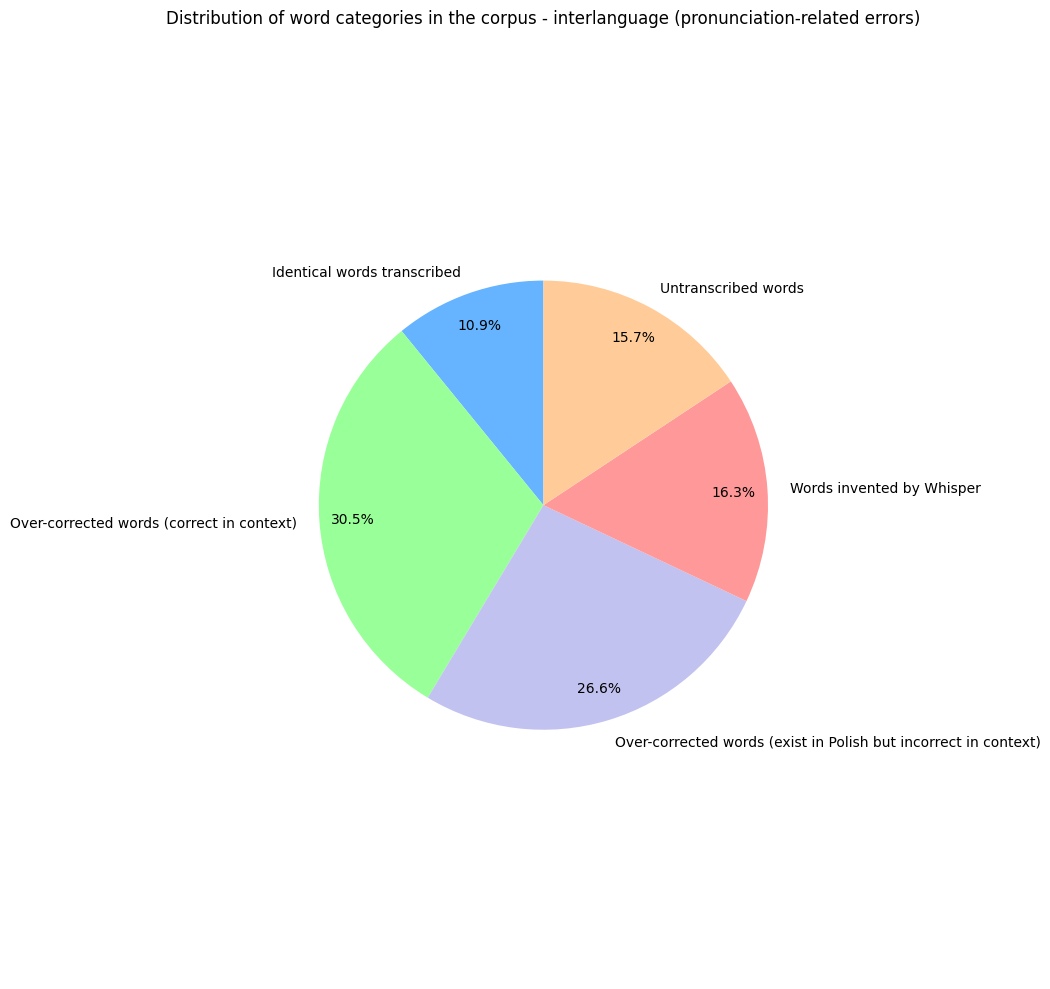

In [2]:
# Initialiser les compteurs par catégorie
groupes_stats = {
    "identiques": 0,
    "surcorriges_context": 0,
    "surcorriges": 0,
    "inventes": 0,
    "non_transcrits": 0,
}

# Lecture du fichier corrigé (prononciation)
total_interlangue = 0

with open("interlangue_prononciation.csv", encoding="utf-8") as f:
    reader = csv.DictReader(f)
    for row in reader:
        mot_inter = row["mot (interlangue)"].strip().lower()
        mots_auto = row["mot (automatique)"].strip().lower()
        mot_correct = row["mot (correct en polonais)"].strip().lower()

        if not mot_inter:
            continue

        total_interlangue += 1

        # === Déterminer la catégorie ===
        if mots_auto == "-":
            cat = "non_transcrits"
        elif mots_auto == mot_correct:
            cat = "surcorriges_context"
        else:
            candidats = mots_auto.split()
            if mot_inter in candidats:
                cat = "identiques"
            elif any(w in lexique_polonais for w in candidats):
                cat = "surcorriges"
            else:
                cat = "inventes"

        # === Mettre à jour les compteurs ===
        groupes_stats[cat] += 1

# Noms des catégories
groupes_noms = {
    "identiques": "Identical words transcribed",
    "surcorriges_context": "Over-corrected words (correct in context)",
    "surcorriges": "Over-corrected words (exist in Polish but incorrect in context)",
    "inventes": "Words invented by Whisper",
    "non_transcrits": "Untranscribed words",
}

# Affichage des résultats
print(f"Nombre total de mots (interlangue) : {total_interlangue}\n")

for cle, titre in groupes_noms.items():
    total = groupes_stats[cle]
    pct_total = 100 * total / total_interlangue if total_interlangue else 0
    print(f"{titre} : {total} mots ({pct_total:.2f}% du corpus)")

# Diagramme global des catégories
categories = list(groupes_stats.keys())
totaux = [groupes_stats[cat] for cat in categories]
labels_cat = [groupes_noms[cat] for cat in categories]

plt.figure(figsize=(10, 10))
plt.pie(
    totaux,
    labels=labels_cat,
    autopct='%1.1f%%',
    startangle=90,
    pctdistance=0.85,
    labeldistance=1.1,
    colors=['#66b3ff', '#99ff99', '#c2c2f0', '#ff9999', '#ffcc99']
)
plt.title("Distribution of word categories in the corpus - interlanguage (pronunciation-related errors)")
plt.axis('equal')
plt.tight_layout()
os.makedirs("images", exist_ok=True)
plt.savefig("images/camembert_categories.png", dpi=300, bbox_inches='tight')
plt.show()


Nombre total d'exemples analysés : 525

Faithful reproduction (reproduction of the error) : 221 (42.10%)
Overcorrection : 114 (21.71%)
Untranscribed : 43 (8.19%)
Unknown : 39 (7.43%)
Invented form : 108 (20.57%)


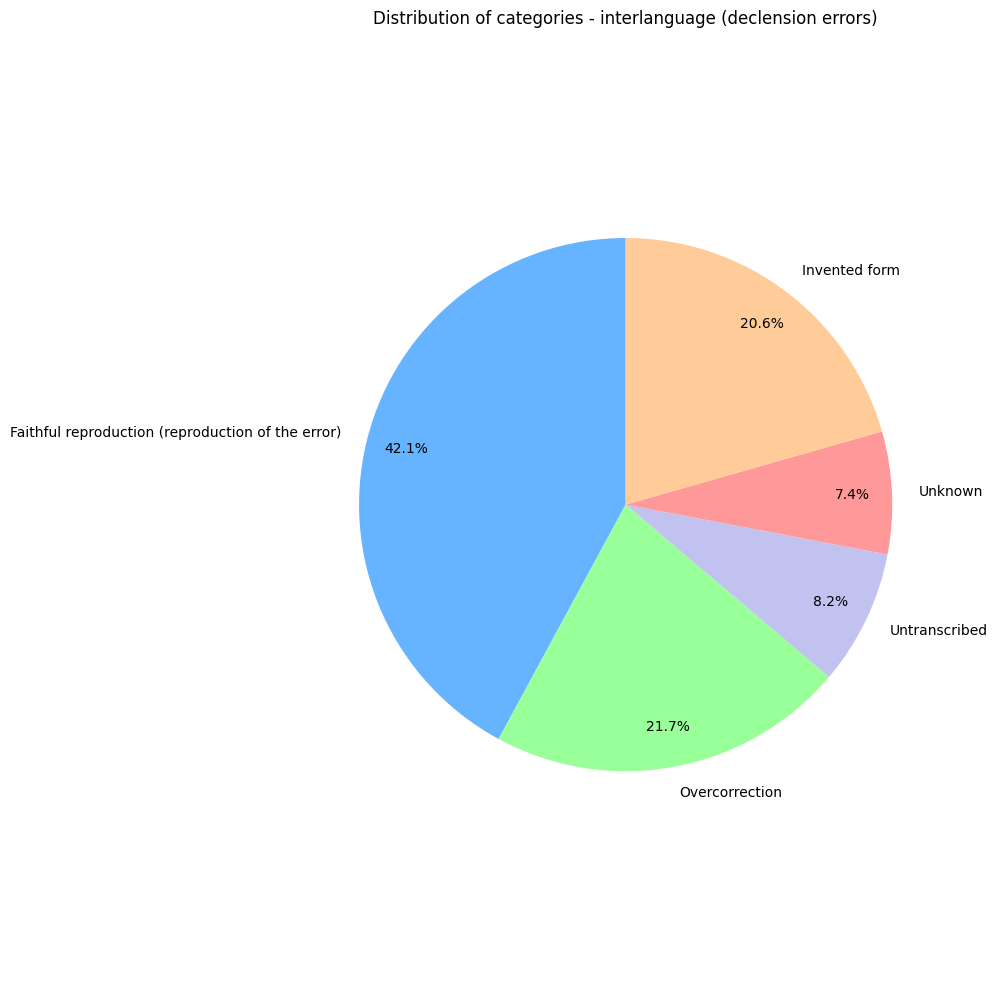

In [3]:
df = pd.read_csv("interlanguage_déclinaison_corrigé_final.csv", encoding="utf-8")

categories_counts = {
    "Faithful reproduction (reproduction of the error)": 0,
    "Overcorrection": 0,
    "Untranscribed": 0,
    "Unknown": 0,
    "Invented form": 0,
}

total = len(df)

for _, row in df.iterrows():
    cas_auto = str(row["cas (mot automatique)"]).strip()
    cas_inter = str(row["cas (interlangue)"]).strip()
    cas_correct = str(row["cas correct"]).strip()

    if cas_inter.lower() in ("nan", "?") or cas_auto.lower() in ("nan", "?") or cas_correct.lower() in ("nan", "?"):
        categories_counts["Unknown"] += 1
        continue

    if cas_auto == cas_inter:
        categories_counts["Faithful reproduction (reproduction of the error)"] += 1
    elif cas_auto == cas_correct and cas_correct != cas_inter:
        categories_counts["Overcorrection"] += 1
    elif cas_auto == "-":
        categories_counts["Untranscribed"] += 1
    else:
        categories_counts["Invented form"] += 1

print(f"Nombre total d'exemples analysés : {total}\n")
for cat, count in categories_counts.items():
    pct = 100 * count / total if total > 0 else 0
    print(f"{cat} : {count} ({pct:.2f}%)")


labels = list(categories_counts.keys())
sizes = list(categories_counts.values())
colors = ['#66b3ff', '#99ff99', '#c2c2f0', '#ff9999', '#ffcc99']

plt.figure(figsize=(10, 10))
plt.pie(
    sizes,
    labels=labels,
    autopct='%1.1f%%',
    startangle=90,
    pctdistance=0.85,
    labeldistance=1.1,
    colors=colors,
)
plt.title("Distribution of categories - interlanguage (declension errors)")
plt.axis('equal')
plt.tight_layout()

os.makedirs("images", exist_ok=True)
plt.savefig("images/camembert_categories_declinaison.png", dpi=300, bbox_inches='tight')
plt.show()
